In [56]:
# Imports
import ast
import os
import math
import pandas as pd
import string
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB


from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import text2emotion as te

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/koen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/koen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/koen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/koen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [57]:
csv_meta = os.path.join(os.getcwd(), 'data', 'metadata.csv')
df_meta = pd.read_csv(csv_meta)
df_meta.dropna(subset=['genre'], inplace=True)

df_meta['genre'] = df_meta['genre'].apply(ast.literal_eval)

# Drop the genres with less than 200 movies
DROPPABLE_GENRES = [
    'Musical',
    'News',
    'Reality-TV',
    'Short',
    'War',
    'Western',
]

mask = df_meta['genre'].apply(lambda genres: not bool(set(genres) & set(DROPPABLE_GENRES)))

df_meta = df_meta[mask]

df_meta['description'] = df_meta['description'].fillna('missing')
df_meta['duration'] = df_meta['duration'].fillna(0)
df_meta['published_at'] = df_meta['published_at'].fillna(0)
df_meta['content_rating'] = df_meta['content_rating'].fillna('Not Rated')

content_rating_replacements = {
    'PG-13': 'Teen',
    'Not Rated': 'Unknown',
    '6': 'Child',
    '12': 'Teen',
    'AL': 'All Ages',
    'PG': 'Child',
    'R': 'Adult',
    '16': 'Adult',
    'G': 'All Ages',
    'MG6': 'Child',
    'Unrated': 'Unknown',
    '9': 'Child',
    'TV-G': 'Child',
    'TV-Y': 'All Ages',
    'T': 'Teen',
    'TV-MA': 'Adult',
    'TV-PG': 'Teen',
    '18': 'Adult',
    'TV-14': 'Adult',
    'Approved': 'All Ages',
    'NC-17': 'Adult',
    '7+': 'Child',
    '15': 'Adult',
    '14': 'Adult',
    '13+': 'Teen',
    'TV-Y7': 'Child'
}

df_meta['content_rating'] = df_meta['content_rating'].replace(content_rating_replacements)

In [58]:
csv_img = os.path.join(os.getcwd(), 'data', 'posters.csv')
df_img = pd.read_csv(csv_img)
df_img = df_img.drop_duplicates(subset='id', keep='first')
df_img = df_img[df_img['id'].isin(df_meta['id'])]

In [59]:
df_img['red_pixels'] = df_img['red_pixels'] / df_img['pixels']
df_img['green_pixels'] = df_img['green_pixels'] / df_img['pixels']
df_img['blue_pixels'] = df_img['blue_pixels'] / df_img['pixels']

In [60]:
objects = set()
for index, row in df_img.iterrows():
    if not pd.isna(row['object detected']):  # Use pd.isna() for checking NaN
        items = row['object detected'].split(", ")
        for item in items:
            object_name = item.split(" ")[0]
            objects.add(object_name)

# Initialize columns for each object with default value of 0
for object_name in objects:
    df_img[object_name] = 0

# Populate the DataFrame with 1s where the object is detected
for index, row in df_img.iterrows():
    if not pd.isna(row['object detected']):  # Use pd.isna() here as well
        items = row['object detected'].split(", ")
        for item in items:
            object_name = item.split(" ")[0]
            df_img.at[index, object_name] = 1

In [61]:
df = pd.merge(df_meta, df_img, on='id')

#### Splitting data

In [62]:
mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(df['genre'])

genre_df = pd.DataFrame(genre_labels, columns=mlb.classes_)

In [63]:
def partial_accuracy_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    matches = (y_true & y_pred).any(axis=1)

    partial_accuracy = matches.mean()
    return partial_accuracy

## Metadata

In [89]:
# Text Vectorization
def clean_text(text):
    text = str(text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert text to lowercase

    text = text.lower()
    # Remove numbers

    text = ''.join([i for i in text if not i.isdigit()])
    # Tokenization

    tokens = word_tokenize(text)
    # Remove stopwords

    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

def get_sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_sentiment_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

meta = df.copy()

meta['title'].apply(clean_text)
meta['description'].apply(clean_text)

vectorizer_title = TfidfVectorizer(max_features=1500)
vectorizer_description = TfidfVectorizer(max_features=5000)

X_title = vectorizer_title.fit_transform(meta['title'])
X_description = vectorizer_description.fit_transform(meta['description'])

encoder = OneHotEncoder()
X_type = encoder.fit_transform(meta[['type']])
X_content_rating = encoder.fit_transform(meta[['content_rating']])

X_duration = meta[['duration']]

X_meta = hstack([
    X_type,
    X_content_rating,
    X_duration,
    X_title,
    X_description
])

In [90]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, genre_df, test_size=0.2, random_state=42)

In [104]:
models_and_parameters = {
    # 'MultiOutput_RandomForestClassifier': {
    #     'model': MultiOutputClassifier(RandomForestClassifier(random_state=42)),
    #     'params': {
    #         'estimator__n_estimators': [50],
    #         'estimator__max_depth': [10],
    #         'estimator__class_weight': ['balanced']
    #     }
    # },
    # 'MultiOutput_SVC': {
    #     'model': MultiOutputClassifier(SVC(random_state=42, probability=True)),
    #     'params': {
    #         'estimator__C': [10],
    #         'estimator__kernel': ['rbf', 'linear'],
    #         'estimator__class_weight': ['balanced']
    #     }
    # },
    # 'MultiOutput_LogisticRegression': {
    #     'model': MultiOutputClassifier(LogisticRegression(random_state=42)),
    #     'params': {
    #         'estimator__C': [20],
    #         'estimator__max_iter': [5000],
    #         'estimator__class_weight': ['balanced']
    #     }
    # },
    'MultiOutput_KNeighborsClassifier': {
        'model': MultiOutputClassifier(KNeighborsClassifier()),
        'params': {
            'estimator__n_neighbors': [3, 5, 10],
            'estimator__weights': ['uniform', 'distance'],
            'estimator__metric': ['euclidean', 'manhattan']
        }
    },
}

In [105]:
f1_scorer = make_scorer(f1_score, average='macro')
results = []

for model_name, mp in models_and_parameters.items():
    clf = GridSearchCV(mp['model'], mp['params'], scoring=f1_scorer, return_train_score=False)
    clf.fit(X_train_meta, y_train_meta)
    results.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    print(f"Tested Model: {model_name}")

Tested Model: MultiOutput_KNeighborsClassifier


In [106]:
for result in results:
    print(result)

{'model': 'MultiOutput_KNeighborsClassifier', 'best_score': 0.19345582088344557, 'best_params': {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 3, 'estimator__weights': 'uniform'}}


In [107]:
model_meta = MultiOutputClassifier(LogisticRegression(C=50, max_iter=5000, class_weight='balanced'))
model_meta.fit(X_train_meta, y_train_meta)

y_pred_meta = model_meta.predict(X_test_meta)

score = partial_accuracy_score(y_test_meta, y_pred_meta)
print(f"Partial Accuracy Score: {score}")

f1_micro = f1_score(y_test_meta, y_pred_meta, average='micro', zero_division=1)
print(f'F1 Score (Micro): {f1_micro}')

f1_macro = f1_score(y_test_meta, y_pred_meta, average='macro', zero_division=1)
print(f'F1 Score (Macro): {f1_macro}')

Partial Accuracy Score: 0.8688845401174168
F1 Score (Micro): 0.5676784249384742
F1 Score (Macro): 0.4827448092003711


## Posters

In [78]:
img = df.copy()

X_img = img[[
    'red_pixels',
    'green_pixels',
    'blue_pixels',
    'weapon',
    'airplane',
    'shield',
    'instrument',
    'woman',
    'car',
    'roses',
    'man',
    'animal',
    'microphone',
]]

X_img.head()

,red_pixels,green_pixels,blue_pixels,weapon,airplane,shield,instrument,woman,car,roses,man,animal,microphone
0,87.517281,83.562936,79.235700,0,1,0,1,0,0,0,1,0,0
1,119.793738,116.520103,139.654135,0,0,0,0,1,0,0,1,0,0
2,36.282090,55.360240,112.865049,0,0,1,1,1,0,1,0,0,0
3,151.958949,183.871269,199.199820,0,0,0,0,1,0,0,1,0,0
4,156.048396,156.145231,179.061729,0,0,0,0,1,0,1,0,0,1


In [73]:
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(X_img, genre_df, test_size=0.2, random_state=42)

In [108]:
model_img = MultiOutputClassifier(LogisticRegression(C=50, max_iter=5000, class_weight='balanced'))
model_img.fit(X_train_img, y_train_img)

y_pred_img = model_img.predict(X_test_img)

score = partial_accuracy_score(y_test_img, y_pred_img)
print(f"Partial Accuracy Score: {score}")

f1_micro = f1_score(y_test_img, y_pred_img, average='micro', zero_division=1)
print(f'F1 Score (Micro): {f1_micro}')

f1_macro = f1_score(y_test_img, y_pred_img, average='macro', zero_division=1)
print(f'F1 Score (Macro): {f1_macro}')

Partial Accuracy Score: 0.8656229615133725
F1 Score (Micro): 0.32150313152400833
F1 Score (Macro): 0.280358015763238


## Combined

In [82]:
combined = df.copy()

X_combined = hstack([
    X_type,
    X_content_rating,
    X_duration,
    X_title,
    X_description,
    X_img[[
        'red_pixels',
        'green_pixels',
        'blue_pixels',
        'weapon',
        'airplane',
        'shield',
        'instrument',
        'woman',
        'car',
        'roses',
        'man',
        'animal',
        'microphone',
    ]]
])

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, genre_df, test_size=0.2, random_state=42)

In [109]:
model = MultiOutputClassifier(LogisticRegression(C=50, max_iter=15000, class_weight='balanced'))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = partial_accuracy_score(y_test, y_pred)
print(f"Partial Accuracy Score: {score}")

f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=1)
print(f'F1 Score (Micro): {f1_micro}')

f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=1)
print(f'F1 Score (Macro): {f1_macro}')

Partial Accuracy Score: 0.8786692759295499
F1 Score (Micro): 0.5806451612903226
F1 Score (Macro): 0.5020553562413682


### Metrics

In [113]:
from sklearn import metrics

# For model_meta
accuracy_meta = metrics.accuracy_score(y_test_meta, y_pred_meta)
precision_meta = metrics.precision_score(y_test_meta, y_pred_meta, average='macro')
recall_meta = metrics.recall_score(y_test_meta, y_pred_meta, average='macro')
f1_score_meta = metrics.f1_score(y_test_meta, y_pred_meta, average='macro')

# For model_img
accuracy_img = metrics.accuracy_score(y_test_img, y_pred_img)
precision_img = metrics.precision_score(y_test_img, y_pred_img, average='macro')
recall_img = metrics.recall_score(y_test_img, y_pred_img, average='macro')
f1_score_img = metrics.f1_score(y_test_img, y_pred_img, average='macro')

# For the combined model
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1_score = metrics.f1_score(y_test, y_pred, average='macro')

print(f"Accuracy for model_meta: {accuracy_meta}")
print(f"Precision for model_meta: {precision_meta}")
print(f"Recall for model_meta: {recall_meta}")
print(f"F1 Score for model_meta: {f1_score_meta}")

print('asdf')

print(f"Accuracy for model_img: {accuracy_img}")
print(f"Precision for model_img: {precision_img}")
print(f"Recall for model_img: {recall_img}")
print(f"F1 Score for model_img: {f1_score_img}")

print('asdf')

print(f"Accuracy for the combined model: {accuracy}")
print(f"Precision for the combined model: {precision}")
print(f"Recall for the combined model: {recall}")
print(f"F1 Score for the combined model: {f1_score}")

Accuracy for model_meta: 0.11285061969993476
Precision for model_meta: 0.503996682198731
Recall for model_meta: 0.46739505105470314
F1 Score for model_meta: 0.4827448092003711
asdf
Accuracy for model_img: 0.0006523157208088715
Precision for model_img: 0.2021237144466166
Recall for model_img: 0.6358141930520483
F1 Score for model_img: 0.280358015763238
asdf
Accuracy for the combined model: 0.1232876712328767
Precision for the combined model: 0.5160744449357557
Recall for the combined model: 0.4943359529096655
F1 Score for the combined model: 0.5020553562413682


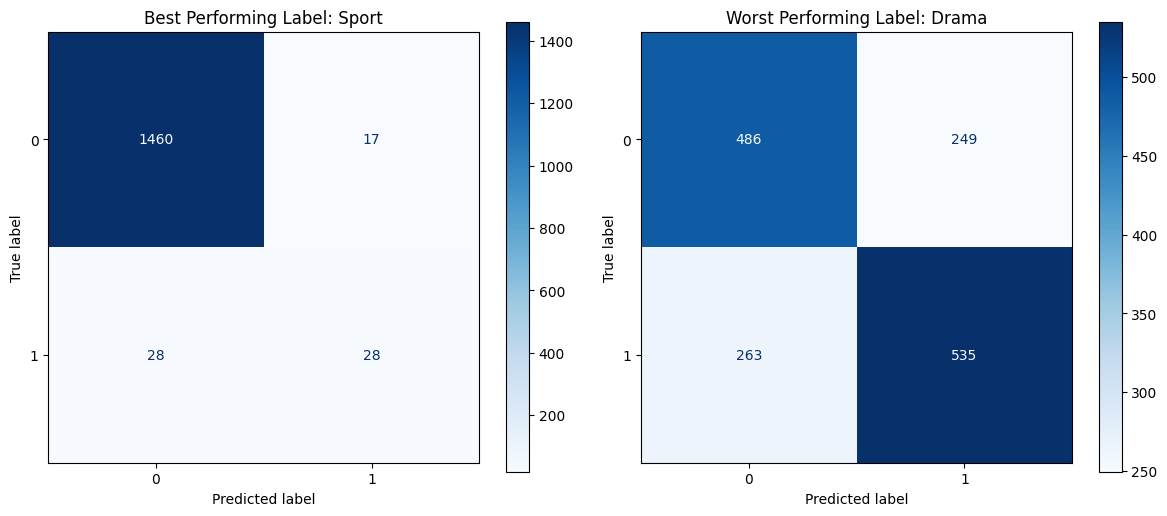

In [125]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to calculate F1 scores for each label
def calculate_f1_scores(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    f1_scores = [f1_score(y_true[:, i], y_pred[:, i], average='weighted') for i in range(y_true.shape[1])]
    return f1_scores

# Function to find the index of the best and worst-performing label based on F1 score
def find_best_worst_indices(f1_scores):
    best_index = f1_scores.index(max(f1_scores))
    worst_index = f1_scores.index(min(f1_scores))
    return best_index, worst_index

# Function to plot confusion matrices for the best and worst-performing labels
def plot_confusion_matrices(y_true, y_pred, best_index, worst_index, genre_df):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Unique classes in best_index
    unique_classes_best = np.unique(np.concatenate((y_true[:, best_index], y_pred[:, best_index])))
    display_labels_best = genre_df.columns[unique_classes_best]

    # Plot best-performing label
    ConfusionMatrixDisplay.from_predictions(y_true[:, best_index], y_pred[:, best_index],
                                            ax=ax[0],
                                            # display_labels=display_labels_best,
                                            cmap=plt.cm.Blues)
    ax[0].set_title('Best Performing Label: {}'.format(genre_df.columns[best_index]))

    # Unique classes in worst_index
    unique_classes_worst = np.unique(np.concatenate((y_true[:, worst_index], y_pred[:, worst_index])))
    display_labels_worst = genre_df.columns[unique_classes_worst]

    # Plot worst-performing label
    ConfusionMatrixDisplay.from_predictions(y_true[:, worst_index], y_pred[:, worst_index],
                                            ax=ax[1],
                                            # display_labels=display_labels_worst,
                                            cmap=plt.cm.Blues)
    ax[1].set_title('Worst Performing Label: {}'.format(genre_df.columns[worst_index]))

    plt.tight_layout()
    plt.show()

# Example for model_meta
f1_scores_meta = calculate_f1_scores(y_test_meta, y_pred_meta)
best_index_meta, worst_index_meta = find_best_worst_indices(f1_scores_meta)
plot_confusion_matrices(y_test_meta, y_pred_meta, best_index_meta, worst_index_meta, genre_df)

# Repeat for model_img and model with y_test_img, y_pred_img and y_test, y_pred respectively.


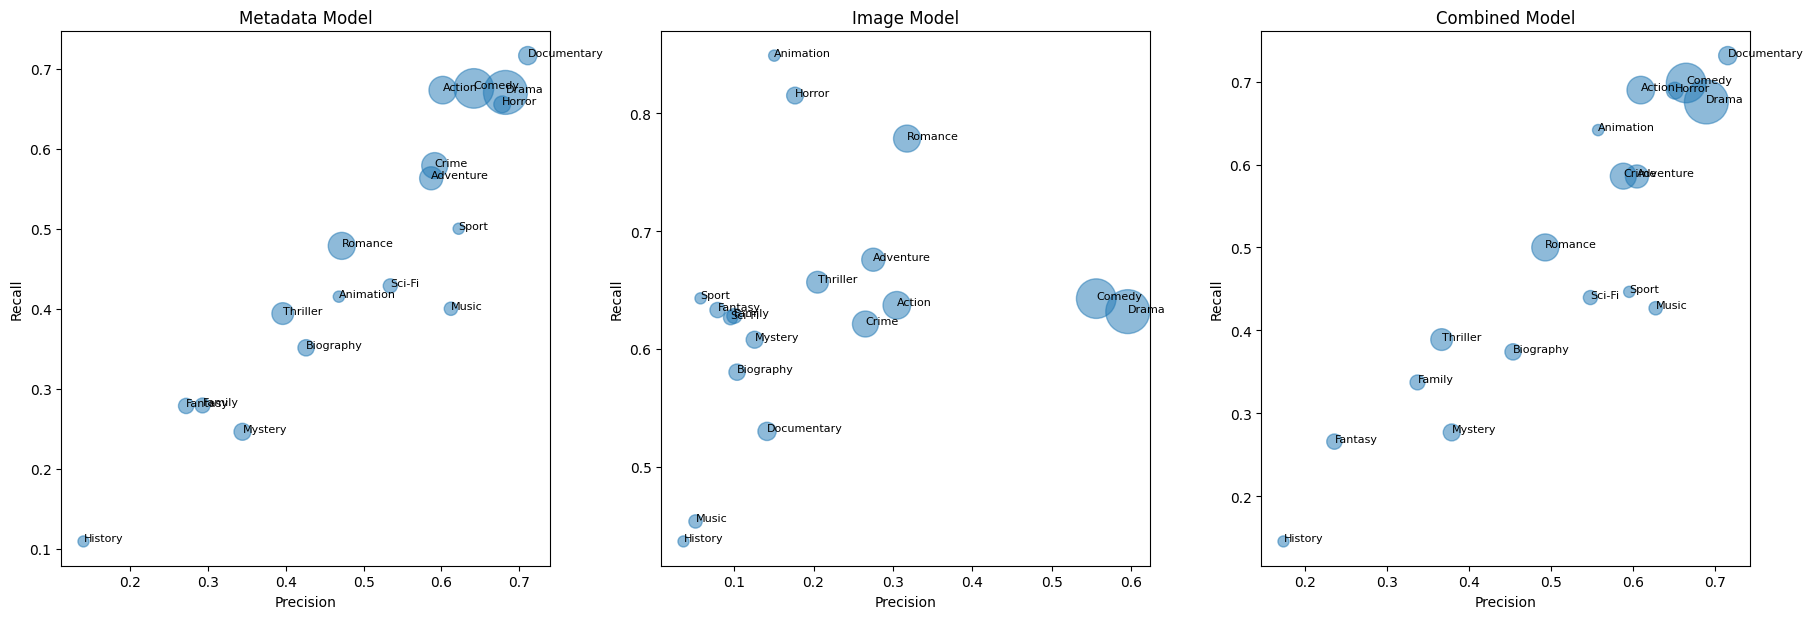

In [134]:
from sklearn.metrics import precision_score, recall_score
import pandas as pd

# Calculate precision and recall per label
label_occurrences = genre_df.sum().values  # Sum each column to get occurrences
precisions_meta = precision_score(y_test_meta, y_pred_meta, average=None)
recalls_meta = recall_score(y_test_meta, y_pred_meta, average=None)

precisions_img = precision_score(y_test_img, y_pred_img, average=None)
recalls_img = recall_score(y_test_img, y_pred_img, average=None)

precisions = precision_score(y_test, y_pred, average=None)
recalls = recall_score(y_test, y_pred, average=None)

# Update DataFrame with these values
precision_recall_df = pd.DataFrame({
    'Label': genre_df.columns,
    'Occurrences': label_occurrences,
    'Precision_Meta': precisions_meta,
    'Recall_Meta': recalls_meta,
    'Precision_Img': precisions_img,
    'Recall_Img': recalls_img,
    'Precision_Combined': precisions,
    'Recall_Combined': recalls
})

# print(precision_recall_df)


import matplotlib.pyplot as plt

def plot_precision_recall(df, precision_col, recall_col, title, ax):
    sizes = (df['Occurrences'] / max(df['Occurrences'])) * 1000  # Adjust sizes
    scatter = ax.scatter(df[precision_col], df[recall_col], s=sizes, alpha=0.5)
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
    ax.set_title(title)
    # Optional: annotate points
    for i, label in enumerate(df['Label']):
        ax.annotate(label, (df[precision_col][i], df[recall_col][i]), fontsize=8)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_precision_recall(precision_recall_df, 'Precision_Meta', 'Recall_Meta', 'Metadata Model', axs[0])
plot_precision_recall(precision_recall_df, 'Precision_Img', 'Recall_Img', 'Image Model', axs[1])
plot_precision_recall(precision_recall_df, 'Precision_Combined', 'Recall_Combined', 'Combined Model', axs[2])

plt.subplots_adjust(wspace=0.5, hspace=0.1) # Adjust spacing here, smaller values = less space
plt.tight_layout(pad=0) # Adjust the padding here
plt.show()
